In [ ]:
# !pip install 'syft[udacity]'

In [ ]:
import os
import pandas as pd
import random
import argparse
import requests
import zipfile
from tqdm import tqdm

import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

import copy
from numpy.random import default_rng
random.seed(1)
from google.colab import files

In [ ]:
import syft as sy
hook = sy.TorchHook(torch)

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.4.so'


In [ ]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
def download_datasets():
    """ Download and unzip the NASA turbofan dataset. """
    file_name = "data.zip"
    url = "http://ti.arc.nasa.gov/c/6/"
    response = requests.get(url, stream=True)
    with open(file_name, "wb") as handle:
        for data in tqdm(response.iter_content()):
            handle.write(data)

    my_zip = zipfile.ZipFile('data.zip')
    storage_path = './data/'
    for file in my_zip.namelist():
        if my_zip.getinfo(file).filename.endswith('.txt'):
            my_zip.extract(file, storage_path)

    os.remove(file_name)


def import_data(dataset_id):

    # define the columns in the dataset
    operational_settings = ['operational_setting_{}'.format(i + 1) for i in range(3)]
    sensor_columns = ['sensor_measurement_{}'.format(i + 1) for i in range(23)]
    cols = ['engine_no', 'time_in_cycles'] + operational_settings + sensor_columns

    # load the data
    dirname = os.getcwd()
    folder_path = os.path.join(dirname, 'data')

    train_path = os.path.join(folder_path, 'train_{}.txt'.format(dataset_id))
    train_data = pd.read_csv(train_path, delim_whitespace=True, header=None, names=cols)
    train_data.set_index('time_in_cycles')
    test_path = os.path.join(folder_path, 'test_{}.txt'.format(dataset_id))
    test_data = pd.read_csv(test_path, delim_whitespace=True, header=None, names=cols)
    test_data.set_index('time_in_cycles')
    test_data_rul_path = os.path.join(folder_path, 'RUL_{}.txt'.format(dataset_id))
    test_data_rul = pd.read_csv(test_data_rul_path, delim_whitespace=True, header=None, names=['RUL'])

    return train_data, test_data, test_data_rul


def save_data(train_data, test_data):

    dirname = os.getcwd()
    folder_path = os.path.join(dirname, 'data')

    train_data_path = os.path.join(folder_path, 'train_data.txt')
    train_data.to_csv(train_data_path, index=False)

    test_data_path = os.path.join(folder_path, 'test_data.txt')
    test_data.to_csv(test_data_path, index=False)


def add_rul_to_test_data(test_data, test_data_rul):

    # prepare the RUL file data
    test_data_rul['engine_no'] = test_data_rul.index + 1
    test_data_rul.columns = ['final_rul', 'engine_no']

    # retrieve the max cycles in the test data
    test_rul_max = pd.DataFrame(test_data.groupby('engine_no')['time_in_cycles'].max()).reset_index()
    test_rul_max.columns = ['engine_no', 'max']

    test_data = test_data.merge(test_data_rul, on=['engine_no'], how='left')
    test_data = test_data.merge(test_rul_max, on=['engine_no'], how='left')

    # add the current RUL for every cycle
    test_data['RUL'] = test_data['max'] + test_data['final_rul'] - test_data['time_in_cycles']
    test_data.drop(['max', 'final_rul'], axis=1, inplace=True)

    return test_data


def get_datasets(dataset_id,no_download):

    if not no_download:
        print('Starting download of datasets')
        download_datasets()

    print("\n##########")
    print("Importing data for data set {}".format(dataset_id))
    train_data, test_data, test_data_rul = import_data(dataset_id)
    test_data = add_rul_to_test_data(test_data, test_data_rul)

    print(train_data.shape)
    print(test_data.shape)


    print("Saving data sets")
    save_data(train_data, test_data)
    print("Done")
    print("##########")

get_datasets('FD001',False)

Starting download of datasets


12425978it [01:14, 165686.14it/s]



##########
Importing data for data set FD001
(20631, 28)
(13096, 29)
Saving data sets
Done
##########


In [ ]:
def process_data():
  # load the data 
  dirname = os.getcwd()
  folder_path = os.path.join(dirname, './data')

  train_data_path = os.path.join(folder_path, 'train_data.txt')
  train_data = pd.read_csv(train_data_path)
  train_data.set_index('time_in_cycles')

  test_data_path = os.path.join(folder_path, 'test_data.txt')
  test_data = pd.read_csv(test_data_path)
  test_data.set_index('time_in_cycles')

  # retrieve the max cycles per engine: RUL
  train_rul = pd.DataFrame(train_data.groupby('engine_no')['time_in_cycles'].max()).reset_index()
  # merge the RULs into the training data
  train_rul.columns = ['engine_no', 'max']
  train_data = train_data.merge(train_rul, on=['engine_no'], how='left')
  # add the current RUL for every cycle
  train_data['RUL'] = train_data['max'] - train_data['time_in_cycles']
  train_data.drop('max', axis=1, inplace=True)

  # drop the columns not needed
  cols_nan = train_data.columns[train_data.isna().any()].tolist()
  cols_const = [ col for col in train_data.columns if len(train_data[col].unique()) <= 2 ]

  cols_irrelevant = ['operational_setting_1', 'operational_setting_2', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13']

  # Drop the columns without or with constant data
  train_data = train_data.drop(columns=cols_const + cols_nan + cols_irrelevant)
  test_data = test_data.drop(columns=cols_const + cols_nan + cols_irrelevant)

  # define the columns for training
  train_data_inputs = train_data.copy()
  train_data_inputs.drop(columns=['RUL', 'engine_no', 'time_in_cycles'], inplace=True)
  training_columns = train_data_inputs.columns

  return train_data, test_data,training_columns

In [ ]:
WINDOW_SIZE = 80
def transform_to_windowed_data(dataset, window_size, window_limit = 0, verbose = True):

  features = []
  labels = []

  dataset = dataset.set_index('time_in_cycles')
  data_per_engine = dataset.groupby('engine_no')

  for engine_no, engine_data in data_per_engine:
      # skip if the engines cycles are too few
      if len(engine_data) < window_size + window_limit -1:
        continue

      if window_limit != 0:
        window_count = window_limit
      else:
        window_count = len(engine_data) - window_size

      for i in range(0, window_count):
        # take the last x cycles where x is the window size
        start = -window_size - i
        end = len(engine_data) - i
        inputs = engine_data.iloc[start:end]
        # use the RUL of the last cycle as label
        outputs = engine_data.iloc[end - 1, -1]

        inputs = inputs.drop(['engine_no', 'RUL'], axis=1)

        features.append(inputs.values)
        labels.append(outputs)

  features = np.array(features)
  labels = np.array(labels)
  labels = np.expand_dims(labels, axis=1)

  if verbose:
    print("{} features with shape {}".format(len(features), features[0].shape))
    print("{} labels with shape {}".format(len(labels), labels.shape))

  return features, labels

In [ ]:
def process_data_final(num_wokers):
  train_data,test_data,training_columns = process_data()
  x_train, y_train = transform_to_windowed_data(train_data, WINDOW_SIZE)
  x_test, y_test = transform_to_windowed_data(test_data, WINDOW_SIZE)

  # BATCH_SIZE = int(len(x_train) / num_wokers) + 1
  BATCH_SIZE = 500

  # clip RUL values
  rul_clip_limit = 110
  y_train = y_train.clip(max=rul_clip_limit)
  y_test = y_test.clip(max=rul_clip_limit)

  #  Data Normalization

  # transform to torch tensor
  tensor_x_train = torch.Tensor(x_train)
  tensor_y_train = torch.Tensor(y_train)
  tensor_x_test = torch.Tensor(x_test)
  tensor_y_test = torch.Tensor(y_test)
  
  #  Data Normalization
  train_mean = tensor_x_train.mean(0)
  train_std = tensor_x_train.std(0)
  tensor_x_train = (tensor_x_train - train_mean) / train_std

  test_mean = tensor_x_test.mean(0)
  test_std = tensor_x_test.std(0)
  tensor_x_test = (tensor_x_test - test_mean) / test_std

  # create datasets for train, test and validation
  train_dataset = torch.utils.data.TensorDataset(tensor_x_train, tensor_y_train)
  test_dataset = torch.utils.data.TensorDataset(tensor_x_test, tensor_y_test)

  # create data loaders
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

  return train_loader,  test_loader

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        self.fc1 = nn.Linear(11, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, 24)
        self.fc4 = nn.Linear(24, 1)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x[:, -1, :]
        
        return x

In [ ]:
class Workers():
    def __init__(self,n_workers,learning_rate,train_size,test_size,
                 mal_users_size, noise_level, model,train_loader,test_loader):
        self.n_workers = n_workers
        self.batch_size_train = int(train_size / n_workers)
        self.batch_size_test = test_size
        self.learning_rate = learning_rate
        self.mal_users_size = mal_users_size
        self.noise_level = noise_level
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader

        # self.load_datasets()
        self.create_workers()
        self.distribute_data_and_model()

    def load_datasets(self):
        self.train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                                  transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))])),batch_size=self.batch_size_train, shuffle=True)

        self.test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,)) ])),batch_size=self.batch_size_test, shuffle=True)

    def create_workers(self):
        self.workers = []
        for i in range(self.n_workers):
          self.workers += [sy.VirtualWorker(hook, id=f"W{i + 1}")]
        self.secure_worker_1 = sy.VirtualWorker(hook, id="secure_worker_1")
        self.secure_worker_2 = sy.VirtualWorker(hook, id="secure_worker_2")

  
    def get_mal_users(self):
        rng = default_rng()
        self.mal_users = rng.choice(self.n_workers, size=self.mal_users_size, replace=False)
        print(f'Mal Users generated by system are {self.mal_users}')

    def distribute_data_and_model(self):
        criterion = nn.L1Loss()
        self.workers_data = []
        self.workers_targets = []
        self.workers_data_val = []
        self.workers_targets_val = []
        self.workers_models = []
        self.workers_opt = []
        self.get_mal_users()

        for index, (data, target) in enumerate(self.train_loader):
          if index < self.n_workers:
            self.workers_models += [self.model.copy().send(self.workers[index])]
            self.workers_opt += [optim.SGD(params=self.workers_models[index].parameters(),lr=self.learning_rate)]
            if index not in self.mal_users:
              val_index = int(data.shape[0] * 0.2)
              self.workers_data += [data[val_index:].send(self.workers[index])]
              self.workers_targets += [target[val_index:].send(self.workers[index])]
              self.workers_data_val += [data[0:val_index].send(self.workers[index])]
              self.workers_targets_val += [target[0:val_index].send(self.workers[index])]
            else:
              noise = torch.rand(data.shape[0], data.shape[1],data.shape[2]) * self.noise_level
              data = torch.add(noise, data)
              val_index = int(data.shape[0] * 0.2)
              self.workers_data += [data[val_index:].send(self.workers[index])]
              self.workers_targets += [target[val_index:].send(self.workers[index])]
              self.workers_data_val += [data[0:val_index].send(self.workers[index])]
              self.workers_targets_val += [target[0:val_index].send(self.workers[index])]

In [ ]:
class Fairness():
  def __init__(self,models_all, workers_accuracy):
    self.get_mal_users(workers_accuracy)
    self.models_all = models_all.copy()
    self.models_partial = models_all.copy()
    for i in range(len(self.models_partial)):
      i = len(self.models_partial) - i - 1
      if i in self.mal_users:
        self.models_partial.remove(self.models_partial[i])
  
  def get_mal_users(self,data, std_type=1):
    anomalies = []
    
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * std_type
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off

    for index,outlier in enumerate(data):
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(index)
    self.mal_users = anomalies
    print(f'Mal Users computed using tests results by system are {self.mal_users}')

  
  def aggregate_model(self,models):
    model_agrregated = []
    for param in models[0].parameters():
      model_agrregated += [np.zeros(param.shape)]

    for model in models:
      i = 0
      for param in model.parameters():
        model_agrregated[i] += param.detach().numpy()
        i += 1

    model_agrregated = np.array(model_agrregated) / len(models)
    
    return model_agrregated

  def model_aggregation(self):
    model_all_aggregate = self.aggregate_model(self.models_all)
    model_partial_aggregate = self.aggregate_model(self.models_partial)

    self.model_full = Net()
    for i, param in enumerate(self.model_full.parameters()):
      param.data = torch.from_numpy(model_all_aggregate[i]).type('torch.FloatTensor')

    self.model_partial = Net()
    for i, param in enumerate(self.model_partial.parameters()):
      param.data = torch.from_numpy(model_partial_aggregate[i]).type('torch.FloatTensor')

  def perform_fairness_testing(self, workers_object, fl_agent):
    for index, (data, target) in enumerate(workers_object.test_loader):
      secure_workers_model_1 = self.model_full.copy().send(workers_object.secure_worker_1)
      secure_workers_model_2 = self.model_partial.copy().send(workers_object.secure_worker_2)
      secure_workers_data_1 = data.send(workers_object.secure_worker_1)
      secure_workers_targets_1 = target.send(workers_object.secure_worker_1)
      secure_workers_data_2 = data.send(workers_object.secure_worker_2)
      secure_workers_targets_2 = target.send(workers_object.secure_worker_2)

    accuracy_full =  fl_agent.test_worker(secure_workers_model_1,secure_workers_data_1, 
                            secure_workers_targets_1,workers_object.batch_size_test)
    
    accuracy_partial =  fl_agent.test_worker(secure_workers_model_2,secure_workers_data_2, 
                            secure_workers_targets_2,workers_object.batch_size_test)
    
    return accuracy_full, accuracy_partial

In [ ]:
class Federated_Learning():
  def __init__(self,n_epochs):
    self.n_epochs = n_epochs

  def train_worker(self,model, optimizer, data, target):
    criterion = nn.L1Loss()
    model.train()
    optimizer.zero_grad()
    pred = model(data)
    loss = criterion(pred, target)
    loss.backward()
    optimizer.step()
    loss = loss.get().data

    return loss

  def test_worker(self,model, data, target, batch_size_test):
    criterion = nn.L1Loss()
    model.eval()
    test_loss = 0

    with torch.no_grad():
      output = model(data)
      loss = criterion(output, target).get()
      return loss.to(dtype=torch.float) 


  def perform_training(self, workers_object):
    train_loss_matrix = np.zeros((workers_object.n_workers,self.n_epochs))
    validation_loss_matrix = np.zeros((workers_object.n_workers,self.n_epochs))
    for epoch in range(self.n_epochs):
      for id in range(workers_object.n_workers):
        loss = self.train_worker(workers_object.workers_models[id], workers_object.workers_opt[id], 
                                 workers_object.workers_data[id], workers_object.workers_targets[id])
        train_loss_matrix[id][epoch] = loss
        loss = self.test_worker(workers_object.workers_models[id],workers_object.workers_data_val[id],
                                workers_object.workers_targets_val[id], 1)
        validation_loss_matrix[id][epoch] = loss
    return train_loss_matrix, validation_loss_matrix

  def perform_testing(self,workers_object):
    model_to_test = []
    n_workers = workers_object.n_workers 
    model_correctness = np.zeros((n_workers, n_workers))
    data_correctness = np.zeros((n_workers,n_workers))
    workers_accuracy = np.zeros((2,n_workers))

    for owner in range(n_workers):
      model_to_test += [workers_object.workers_models[owner].get()]

      for tester in range(n_workers):
        if owner != tester or True:
          test_model = model_to_test[owner].copy().send(workers_object.workers[tester])
          loss =  self.test_worker(test_model, workers_object.workers_data[tester], 
                                       workers_object.workers_targets[tester],workers_object.batch_size_test)
          model_correctness[owner][tester] += loss  # Tests for model correctness
          data_correctness[tester][owner] += loss # Tests for data correctness
          workers_accuracy[0][owner] += loss  # Tests for model correctness
          workers_accuracy[1][tester] += loss # Tests for data correctness
          # Return the sent model, to clear the tester device from all models except owned model.
          test_model.get() 

    workers_accuracy = workers_accuracy / (n_workers - 1)

    return workers_accuracy, model_to_test, model_correctness, data_correctness


In [ ]:
model_original = Net()

In [ ]:
def run_exp(num_worker, n_epoch,lr, train_size, test_size,mal_users_size,noise_level,aggregated_loss):
  train_loader, test_loader = process_data_final(num_worker)
  workers_object = Workers(num_worker, lr, train_size, test_size,mal_users_size,noise_level,model_original, train_loader, test_loader)

  fl_agent = Federated_Learning(n_epoch)
  train_loss_matrix, validation_loss_matrix = fl_agent.perform_training(workers_object)
  accuracy_results,model_all, model_correctness, data_correctness = fl_agent.perform_testing(workers_object)

  fair_fed = Fairness(model_all,accuracy_results[1])
  fair_fed.model_aggregation()

  loss_with_outlier, loss_without_outlier = fair_fed.perform_fairness_testing(workers_object,fl_agent)
  i = int((num_worker - 4) / 2)
  aggregated_loss[i,0] = loss_with_outlier
  aggregated_loss[i,1] = loss_without_outlier
  print(f'Loss With Outlier: {loss_with_outlier}')
  print(f'Loss Without Outlier: {loss_without_outlier}')

  return train_loss_matrix, validation_loss_matrix,model_correctness, data_correctness

In [ ]:
def start_round(num_workers,aggregated_loss):
  fig_size = (7,7)
  train_loss_matrix, validation_loss_matrix, model_correctness, data_correctness = run_exp(num_workers,300,0.1,12631,5583,1,5,aggregated_loss)
  epochs = [(i + 1) for i in range(len(train_loss_matrix[0][200:]))]
  plt.figure(figsize = fig_size)
  plt.xlabel('Epoch')
  for i in range(len(train_loss_matrix)):
    plt.plot(epochs, train_loss_matrix[i][200:], label=f'Train Loss ID: {i + 1} ')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.title("Training Loss for Each work")
  # plt.ylim((np.min(train_loss_matrix),np.max(train_loss_matrix)))
  plt.savefig(f'training_loss_{num_workers}.png')

  plt.figure(figsize = fig_size)
  plt.xlabel('Epoch')
  for i in range(len(validation_loss_matrix)):
    plt.plot(epochs, validation_loss_matrix[i][200:], label=f'Validation Loss ID: {i + 1} ')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.title("Validation Loss for Each work")
  plt.savefig(f'validation_loss_{num_workers}.png')

  ids = [(i + 1) for i in range(len(model_correctness[0]))]
  plt.figure(figsize = fig_size)
  plt.xlabel('Workers')
  plt.ylabel('Loss')
  for i in range(len(model_correctness)):
    plt.plot(ids, model_correctness[i], label=f' Model Loss for worker ID: {i + 1} ')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.title("Loss when each worker model is tested against other workers datasets")
  plt.savefig(f'model_loss_{num_workers}.png')

  ids = [(i + 1) for i in range(len(data_correctness[0]))]
  plt.figure(figsize = fig_size)
  plt.xlabel('Workers')
  plt.ylabel('Loss')
  for i in range(len(data_correctness)):
    plt.plot(ids, data_correctness[i], label=f' Data Loss for worker ID: {i + 1} ')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.title("Loss when other workers' models are tested in each worker datasets")
  plt.savefig(f'data_loss_{num_workers}.png')

12631 features with shape (80, 11)
12631 labels with shape (12631, 1)
5583 features with shape (80, 11)
5583 labels with shape (5583, 1)
Mal Users generated by system are [1]
Mal Users computed using tests results by system are [1]
Loss With Outlier: 79.70645904541016
Loss Without Outlier: 60.43105697631836
12631 features with shape (80, 11)
12631 labels with shape (12631, 1)
5583 features with shape (80, 11)
5583 labels with shape (5583, 1)
Mal Users generated by system are [0]
Mal Users computed using tests results by system are [0]
Loss With Outlier: 65.68131256103516
Loss Without Outlier: 51.4959831237793
12631 features with shape (80, 11)
12631 labels with shape (12631, 1)
5583 features with shape (80, 11)
5583 labels with shape (5583, 1)
Mal Users generated by system are [5]
Mal Users computed using tests results by system are [5]
Loss With Outlier: 64.3860855102539
Loss Without Outlier: 58.093902587890625
12631 features with shape (80, 11)
12631 labels with shape (12631, 1)
5583

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_w

12631 features with shape (80, 11)
12631 labels with shape (12631, 1)
5583 features with shape (80, 11)
5583 labels with shape (5583, 1)
Mal Users generated by system are [2]
Mal Users computed using tests results by system are [2]
Loss With Outlier: 55.644065856933594
Loss Without Outlier: 48.689300537109375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_w

12631 features with shape (80, 11)
12631 labels with shape (12631, 1)
5583 features with shape (80, 11)
5583 labels with shape (5583, 1)
Mal Users generated by system are [17]
Mal Users computed using tests results by system are [13, 17]
Loss With Outlier: 59.7740364074707
Loss Without Outlier: 56.657325744628906


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_w

12631 features with shape (80, 11)
12631 labels with shape (12631, 1)
5583 features with shape (80, 11)
5583 labels with shape (5583, 1)
Mal Users generated by system are [0]
Mal Users computed using tests results by system are [0, 13]
Loss With Outlier: 58.85527038574219
Loss Without Outlier: 54.3276481628418


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_w

12631 features with shape (80, 11)
12631 labels with shape (12631, 1)
5583 features with shape (80, 11)
5583 labels with shape (5583, 1)
Mal Users generated by system are [7]
Mal Users computed using tests results by system are [7, 13]
Loss With Outlier: 56.737274169921875
Loss Without Outlier: 53.69012451171875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_w

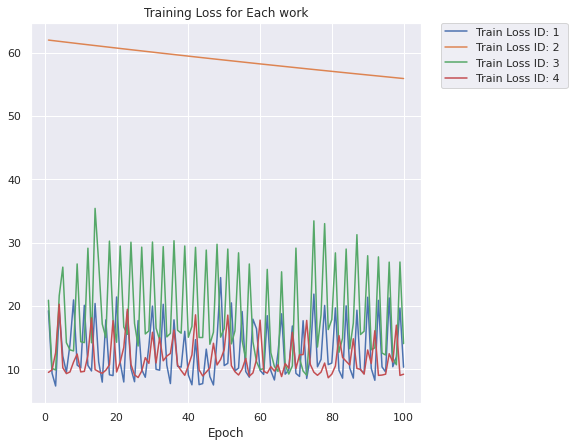

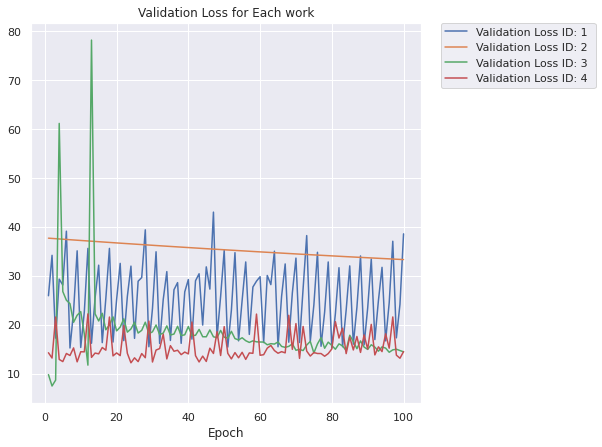

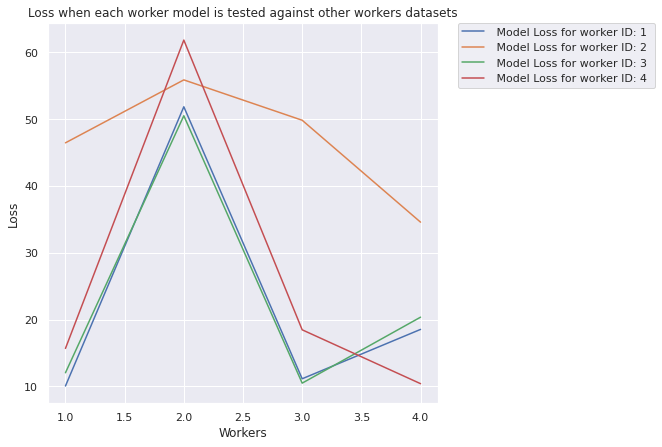

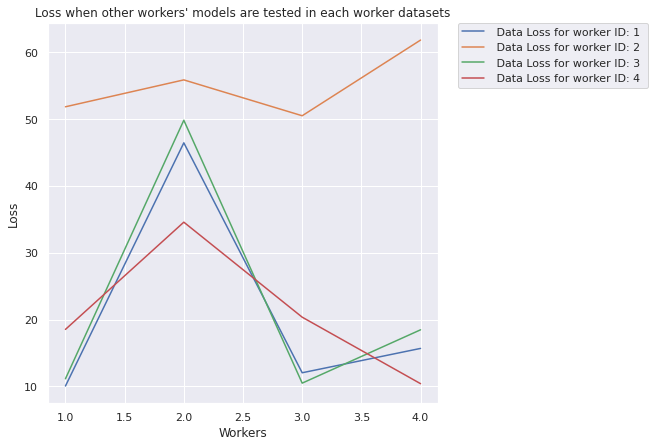

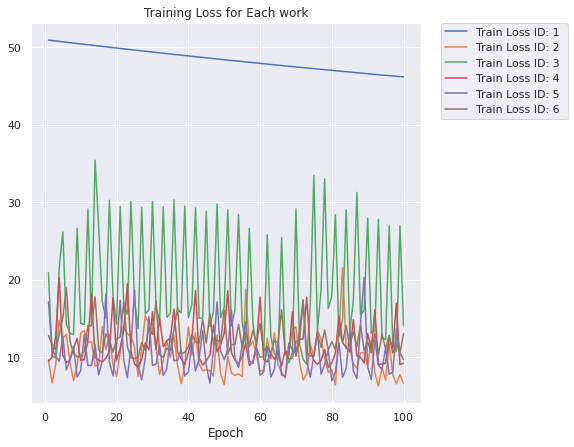

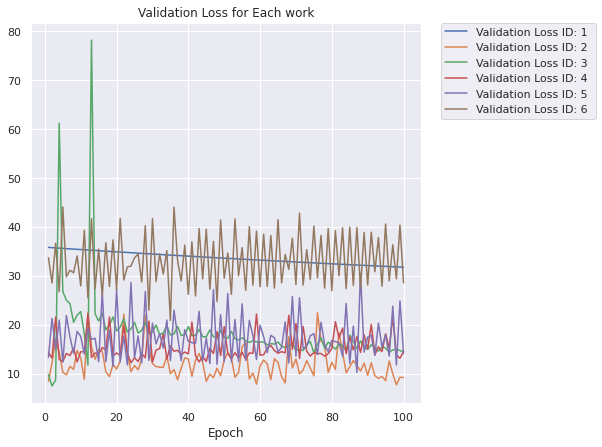

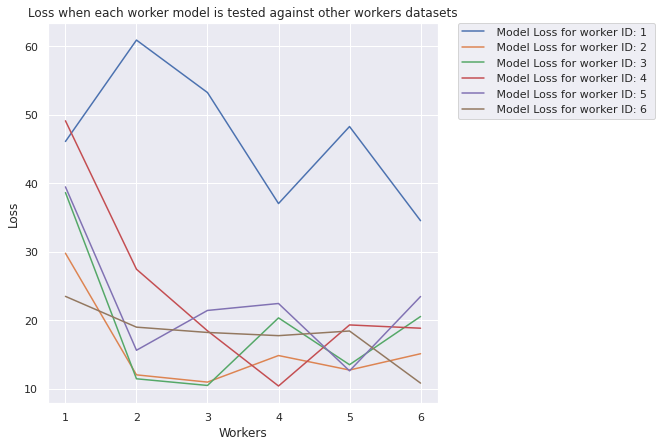

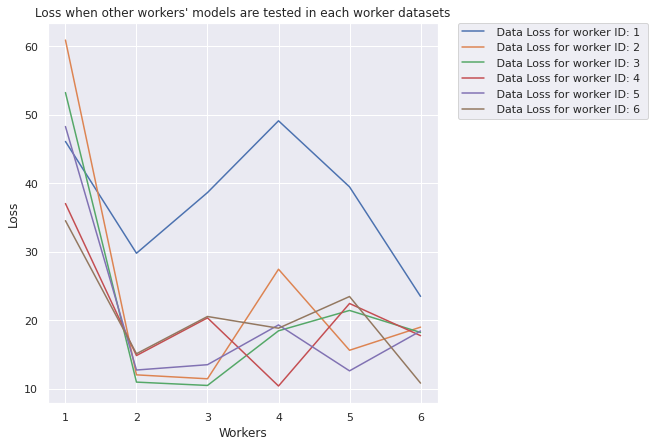

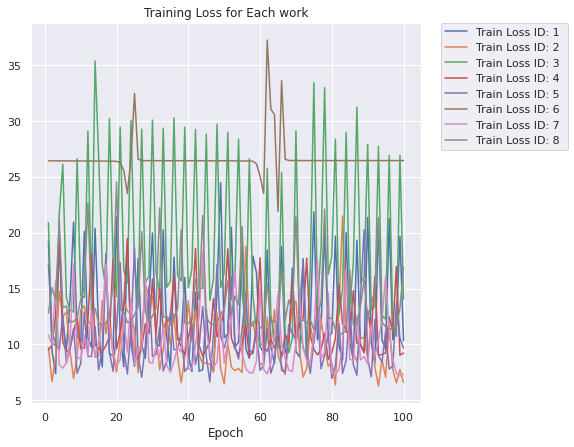

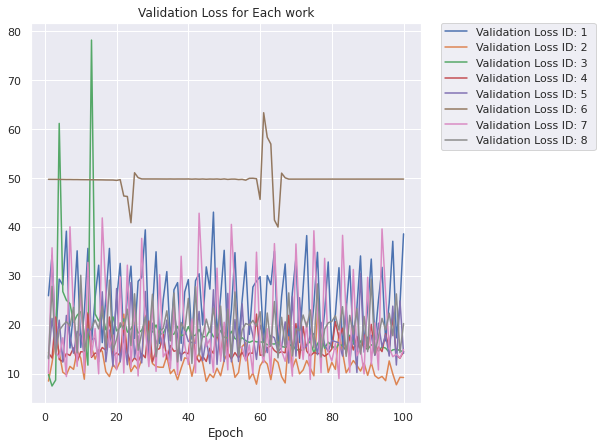

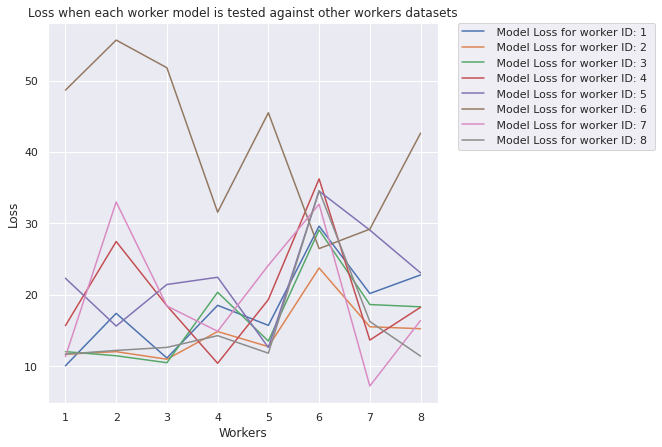

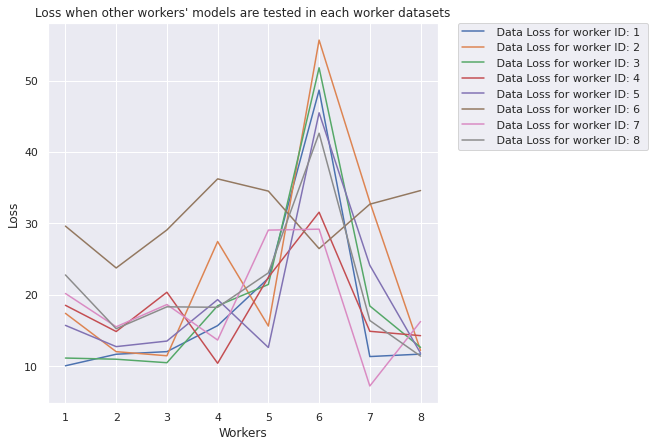

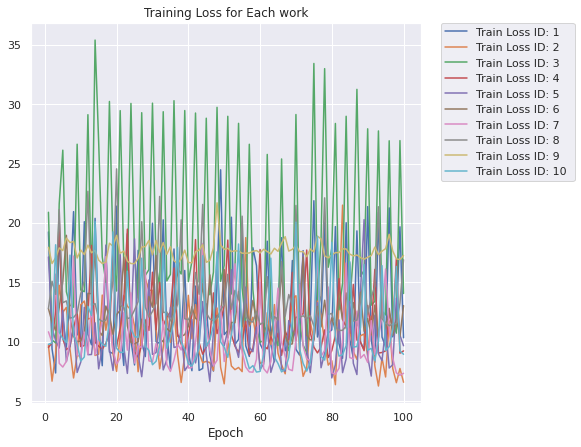

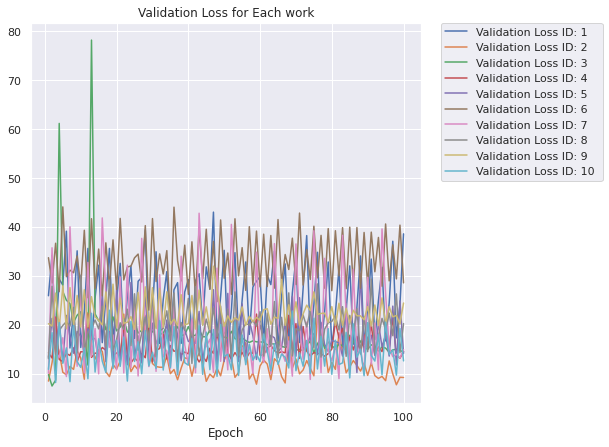

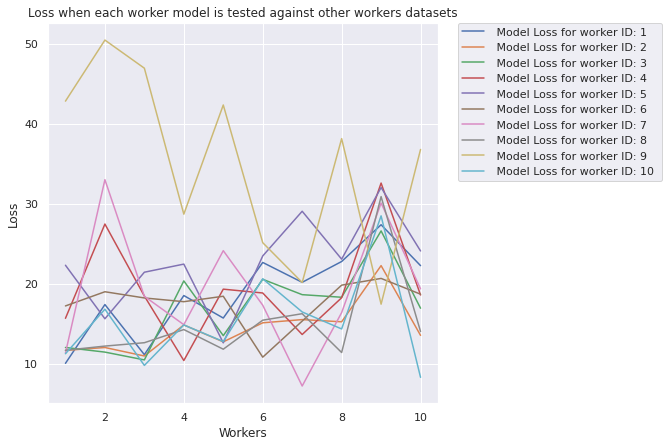

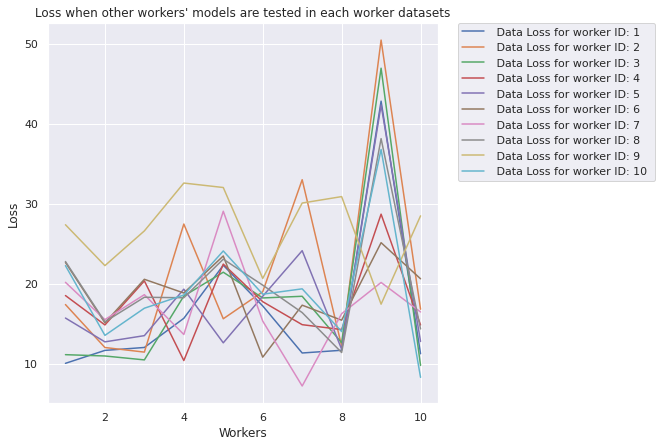

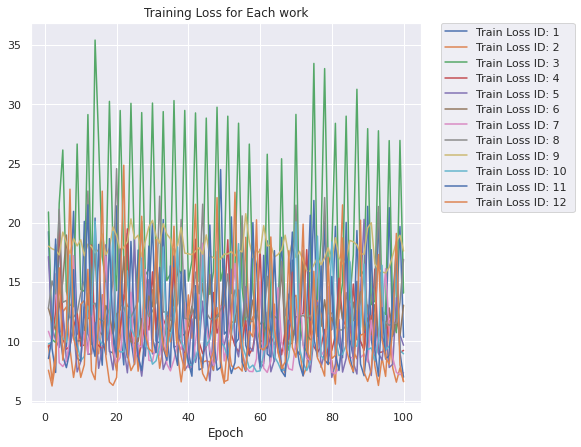

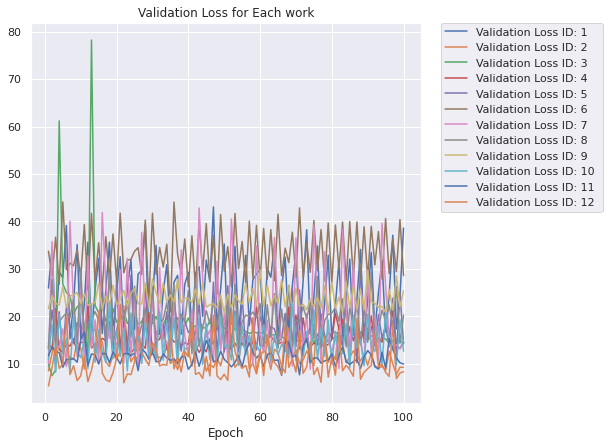

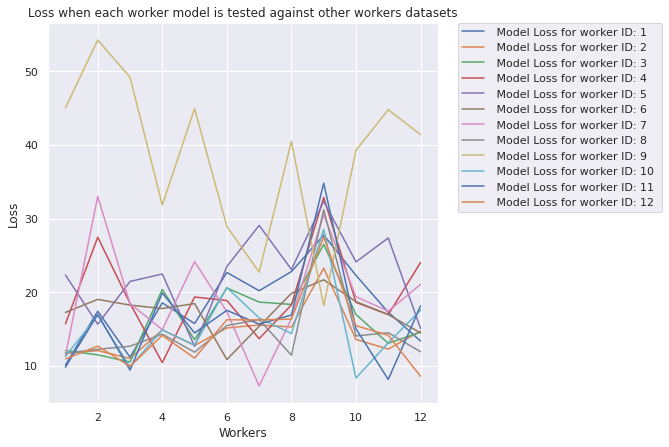

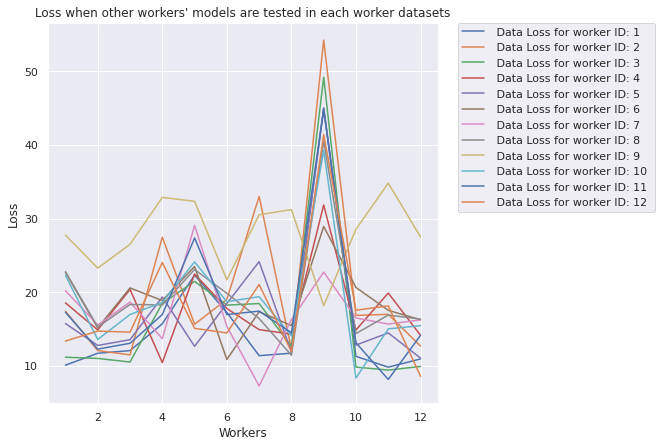

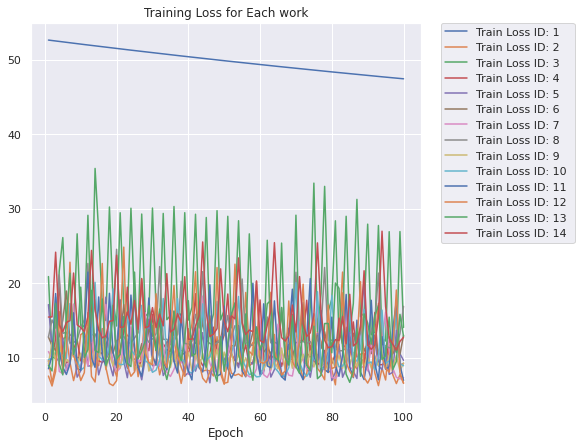

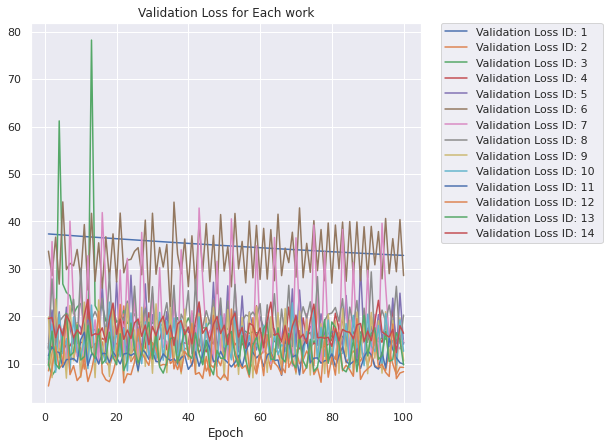

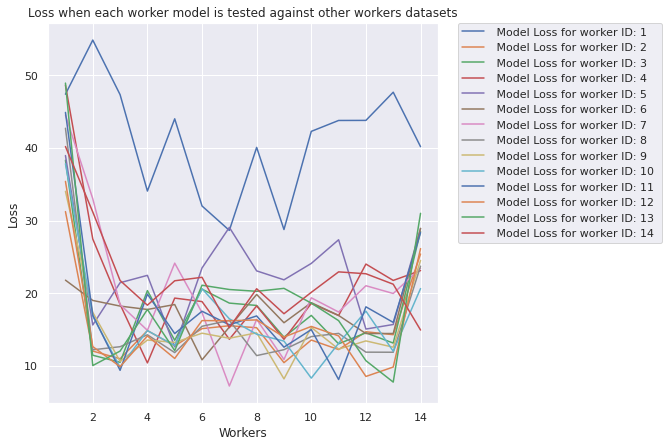

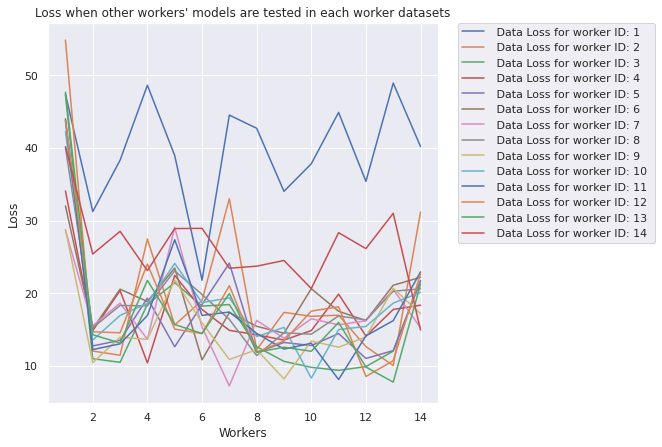

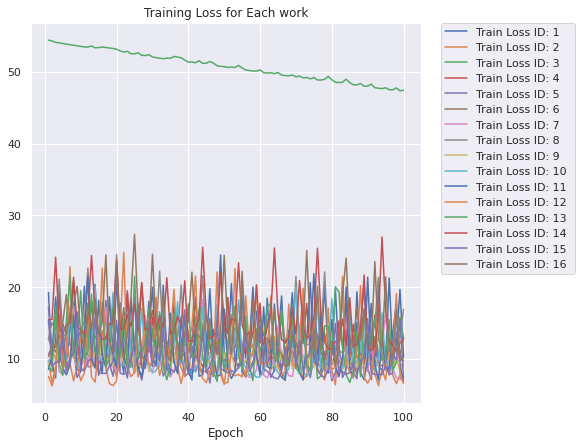

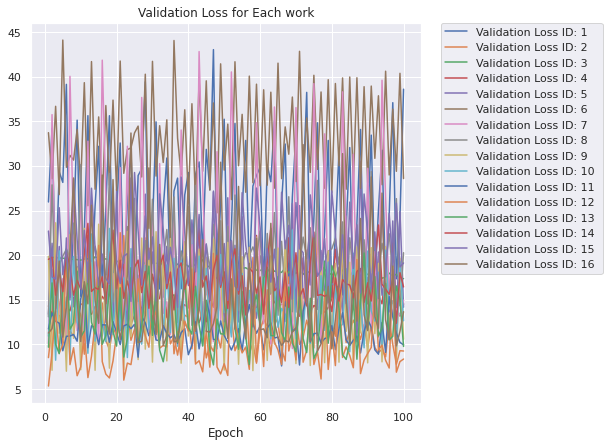

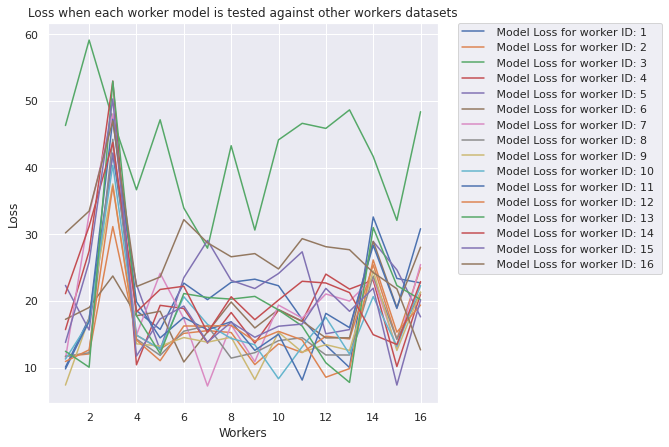

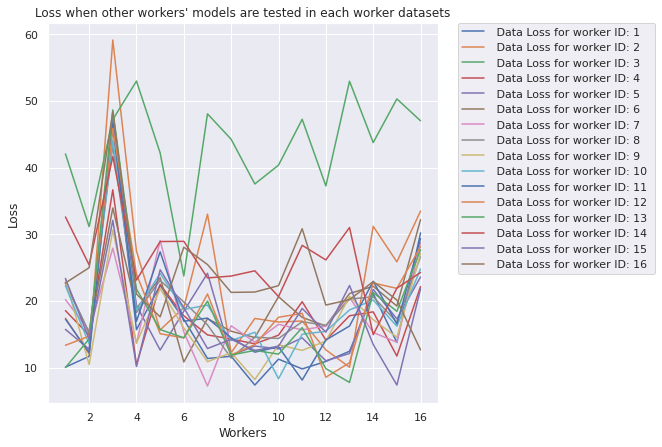

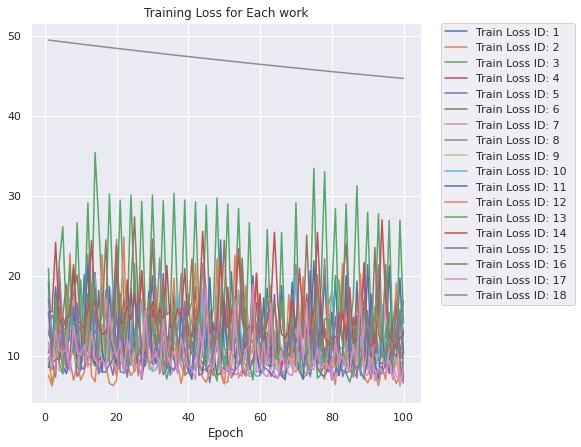

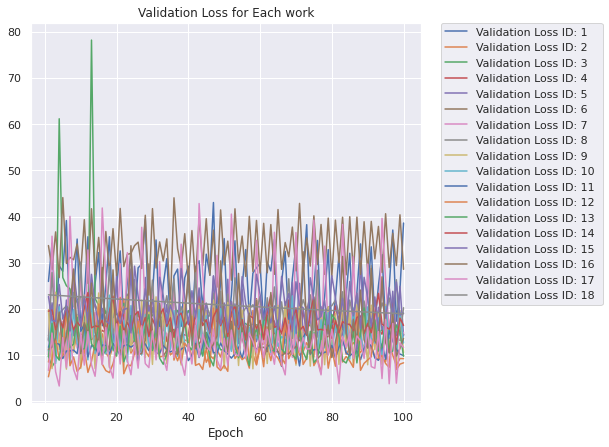

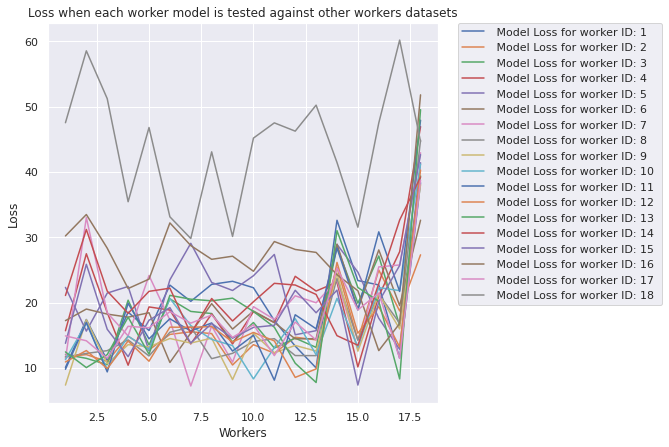

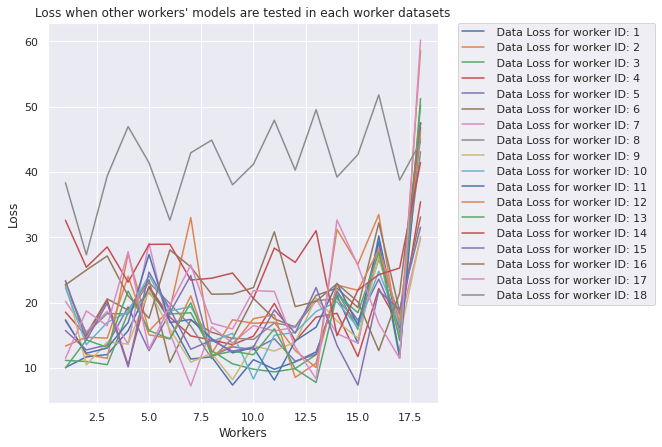

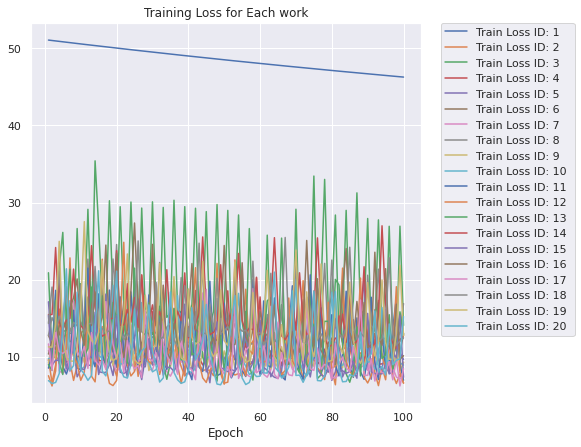

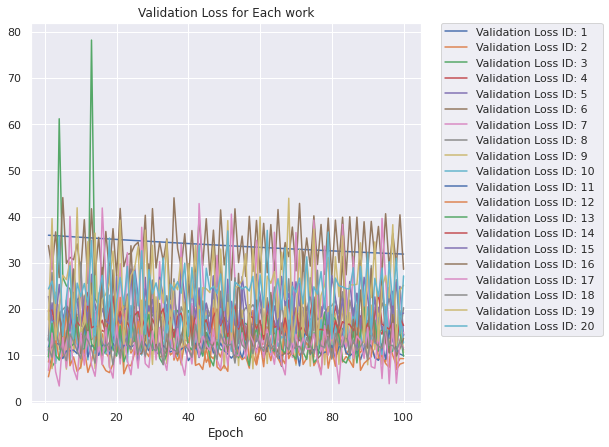

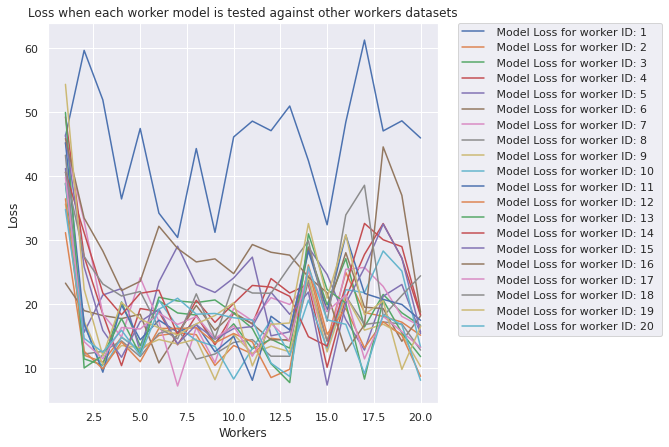

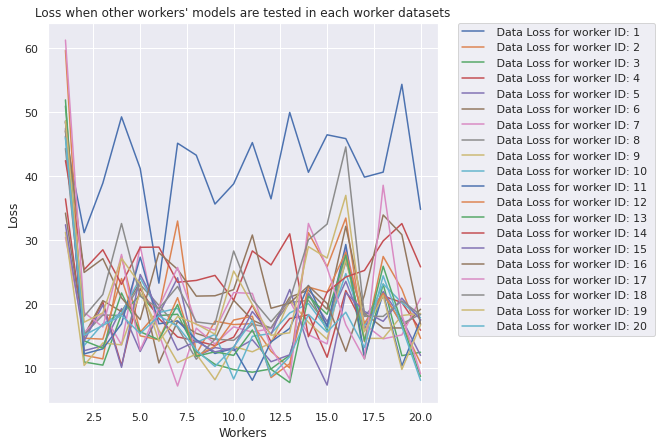

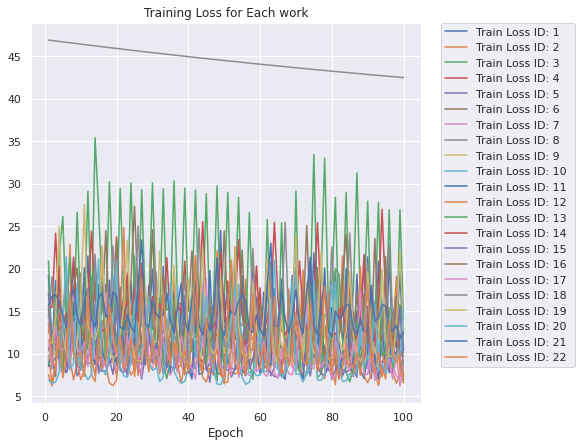

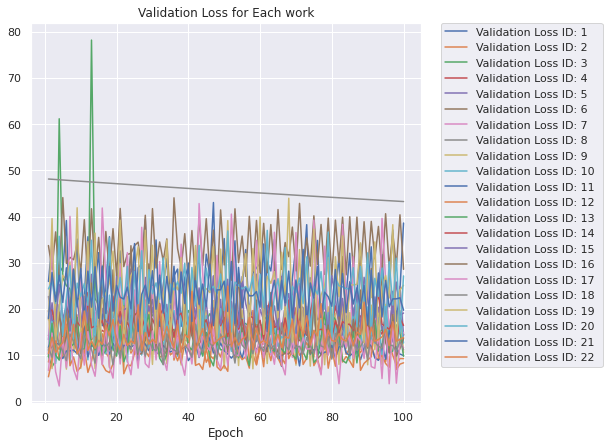

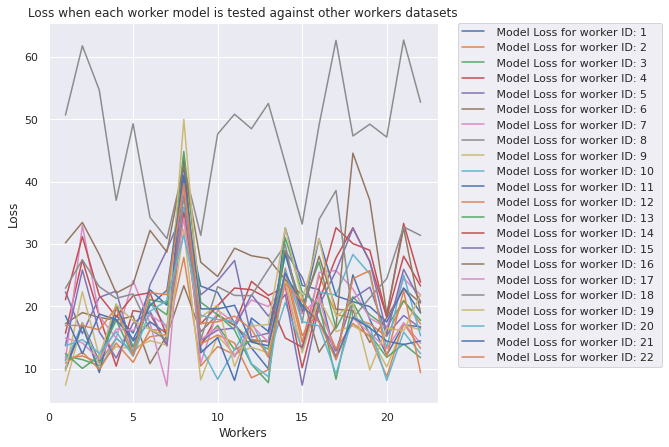

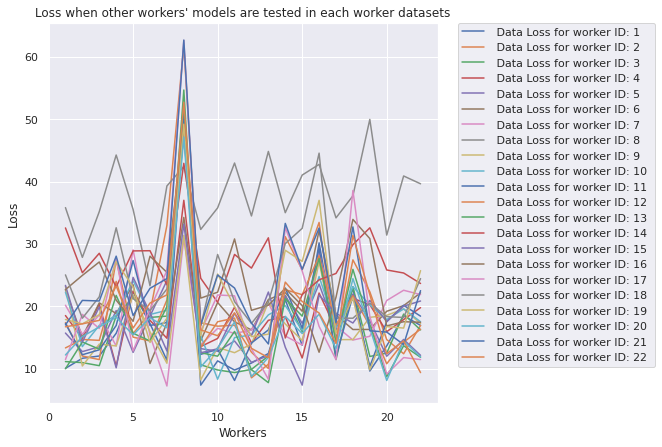

In [ ]:
aggregated_loss = np.zeros((10,2))
for i in range(2,12):
  i = i * 2
  start_round(i,aggregated_loss)

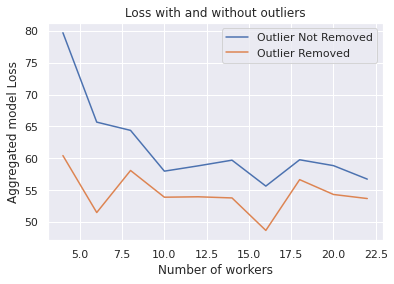

In [ ]:
plt.plot([4,6,8,10,12,14,16,18,20,22], aggregated_loss[:,0], label='Outlier Not Removed')
plt.plot([4,6,8,10,12,14,16,18,20,22], aggregated_loss[:,1], label='Outlier Removed')
plt.legend()
plt.xlabel("Number of workers")
plt.ylabel("Aggregated model Loss")
plt.title("Loss with and without outliers")
plt.savefig(f'Fairnes_Results.png')